# DAT102x: Predicting Evictions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, probplot, norm, boxcox
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
%matplotlib inline

<br>
<br>

# Contents

- [Initial Data Analysis](#Initial-Data-Analysis)
    - [Read in the data](#Read-in-the-data)
    - [Dealing with missing data](#Dealing-with-missing-data)
    - [Transform categorical features](#Transform-categorical-features)
- [Exploratory data analysis](#Exploratory-Data-Analysis)
    - [Feature/Target transformations](#Feature/Target-transformations)
        - [Target variable](#Target-variable)
        - [Over represented features](#Over-represented-features)
        - [Skewed features](#Skewed-features)
        - [Multicollinearity](#Multicollinearity)
- [Machine Learning models](#Machine-Learning-models)

<br>
<br>

# Initial Data Analysis

<br>
<br>

## Read in the data

In [2]:
train_data = pd.read_csv("data/train_values.csv")
train_labels = pd.read_csv("data/train_labels.csv")
test_data = pd.read_csv("data/test_values.csv")
all_data = pd.concat([train_data, test_data])

In [3]:
train_data.head()

,row_id,county_code,year,state,population,renter_occupied_households,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,...,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k
0,0,a4e2211,b,d725a95,45009.0,6944.0,37.218,643.0,33315.0,98494.0,...,1960.0,0.532,0.252,0.153,0.233000,0.375000,0.278000,0.114000,12.915129,11.205112
1,1,583e0c7,a,533155c,9872.0,1224.0,31.773,517.0,43724.0,85444.0,...,890.0,0.509,0.252,0.188,0.073293,0.397590,0.331325,0.197791,11.049159,12.276843
2,2,4776bfd,b,d725a95,17625.0,1725.0,21.973,671.0,37777.0,136162.0,...,3509.0,0.451,0.166,0.189,0.206587,0.303393,0.301397,0.188623,7.903576,10.161741
3,3,97fb48d,a,d725a95,134136.0,18180.0,36.809,603.0,30607.0,70062.0,...,2219.0,0.519,0.263,0.125,0.248255,0.334995,0.290130,0.126620,13.137119,10.202072
4,4,47a9ba3,a,be99678,6936.0,551.0,17.627,668.0,44237.0,187066.0,...,3410.0,0.487,0.196,0.203,0.058648,0.276342,0.413519,0.251491,6.084752,5.939877


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Data columns (total 48 columns):
row_id                                        2546 non-null int64
county_code                                   2546 non-null object
year                                          2546 non-null object
state                                         2546 non-null object
population                                    2546 non-null float64
renter_occupied_households                    2546 non-null float64
pct_renter_occupied                           2546 non-null float64
median_gross_rent                             2546 non-null float64
median_household_income                       2544 non-null float64
median_property_value                         2544 non-null float64
rent_burden                                   2546 non-null float64
pct_white                                     2546 non-null float64
pct_af_am                                     2546 non-null float64
pct_hispanic  

2546/2420 entries (Train/Test)

### Data fields

ID
- `county_code` - Unique identifier for each county
- `year` - Year, denoted as a or b
- `state` - Unique identifier for each state
- `population` - Total population

HOUSING
- `renter_occupied_households` - Count of renter-occupied households
- `pct_renter_occupied` - Percent of occupied housing units that are renter-occupied
- `median_gross_rent` - Median cost of rent
- `median_household_income` - Median household income
- `median_property_value` - Median property value
- `rent_burden` - Median gross rent as a percentage of household income

ETHNICITY
- `pct_white` - Percent of population that is White alone and not Hispanic or Latino
- `pct_af_am` - Percent of population that is Black or African American alone and not Hispanic or Latino
- `pct_hispanic` - Percent of population that is of Hispanic or Latino origin
- `pct_am_ind` - Percent of population that is American Indian and Alaska Native alone and not Hispanic or Latino
- `pct_asian` - Percent of population that is Asian alone and not Hispanic or Latino
- `pct_nh_pi` - Percent of population that is Native Hawaiian and Other Pacific Islander alone and not Hispanic or Latino
- `pct_multiple` - Percent of population that is two or more races and not Hispanic or Latino
- `pct_other` - Percent of population that is other race alone and not Hispanic or Latino

ECONOMIC
- `poverty_rate` - Percent of the population with income in the past 12 months below the poverty level
- `rucc` - Rural-Urban Continuum Codes "form a classification scheme that distinguishes metropolitan counties by the population size of their metro area, and nonmetropolitan counties by degree of urbanization and adjacency to a metro area. The official Office of Management and Budget (OMB) metro and nonmetro categories have been subdivided into three metro and six nonmetro categories. Each county in the U.S. is assigned one of the 9 codes." (USDA Economic Research Service)
- `urban_influence` - Urban Influence Codes "form a classification scheme that distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." (USDA Economic Research Service)
- `economic_typology` - County Typology Codes "classify all U.S. counties according to six mutually exclusive categories of economic dependence and six overlapping categories of policy-relevant themes. The economic dependence types include farming, mining, manufacturing, Federal/State government, recreation, and nonspecialized counties. The policy-relevant types include low education, low employment, persistent poverty, persistent child poverty, population loss, and retirement destination." (USDA Economic Research Service)
- `pct_civilian_labor` - Civilian labor force, annual average, as percent of population.
- `pct_unemployment` - Unemployment, annual average, as percent of population

HEALTH
- `pct_uninsured_adults` - Percent of adults without health insurance
- `pct_uninsured_children` - Percent of children without health insurance
- `pct_adult_obesity` - Percent of adults who meet clinical definition of obese
- `pct_adult_smoking` - Percent of adults who smoke
- `pct_diabetes` - Percent of population with diabetes
- `pct_low_birthweight` - Percent of babies born with low birth weight
- `pct_excessive_drinking` - Percent of adult population that engages in excessive consumption of alcohol
- `pct_physical_inactivity` - Percent of adult population that is physically inactive
- `air_pollution_particulate_matter_value` - Fine particulate matter in µg/m³
- `homicides_per_100k` - Deaths by homicide per 100,000 population
- `motor_vehicle_crash_deaths_per_100k` - Deaths by motor vehicle crash per 100,000 population
- `heart_disease_mortality_per_100k` - Deaths from heart disease per 100,000 population
- `pop_per_dentist` - Population per dentist
- `pop_per_primary_care_physician` - Population per Primary Care Physician

DEMOGRAPHIC
- `pct_female` - Percent of population that is female
- `pct_below_18_years_of_age` - Percent of population that is below 18 years of age
- `pct_aged_65_years_and_older` - Percent of population that is aged 65 years or older
- `pct_adults_less_than_a_high_school_diploma` - Percent of adult population that does not have a high school diploma
- `pct_adults_with_high_school_diploma` - Percent of adult population which has a high school diploma as highest level of education achieved
- `pct_adults_with_some_college` - Percent of adult population which has some college as highest level of education achieved
- `pct_adults_bachelors_or_higher` - Percent of adult population which has a bachelor's degree or higher as highest level of education achieved
- `birth_rate_per_1k` - Births per 1,000 of population
- `death_rate_per_1k` - Deaths per 1,000 of population

<br>
<br>

## Dealing with missing data

In [6]:
missing_train_df = train_data.isnull().sum()
missing_train_df = pd.DataFrame(missing_train_df[missing_train_df>0].sort_values(ascending=False), columns=['Total'])
missing_train_df['%'] = np.round((missing_train_df['Total']/len(train_data))*100, decimals=2)
print("Missing features in Train data")
missing_train_df

Missing features in Train data


,Total,%
homicides_per_100k,1598,62.77
pct_excessive_drinking,810,31.81
pct_adult_smoking,408,16.03
motor_vehicle_crash_deaths_per_100k,308,12.10
pop_per_dentist,190,7.46
pop_per_primary_care_physician,175,6.87
pct_low_birthweight,126,4.95
median_property_value,2,0.08
median_household_income,2,0.08
air_pollution_particulate_matter_value,1,0.04


In [7]:
missing_test_df = test_data.isnull().sum()
missing_test_df = pd.DataFrame(missing_test_df[missing_test_df>0].sort_values(ascending=False), columns=['Total'])
missing_test_df['%'] = np.round((missing_test_df['Total']/len(test_data))*100, decimals=2)
print("Missing features in Test data")
missing_test_df

Missing features in Test data


,Total,%
homicides_per_100k,1495,61.78
pct_excessive_drinking,718,29.67
pct_adult_smoking,344,14.21
motor_vehicle_crash_deaths_per_100k,272,11.24
pop_per_dentist,163,6.74
pop_per_primary_care_physician,143,5.91
pct_low_birthweight,107,4.42
air_pollution_particulate_matter_value,3,0.12
median_gross_rent,2,0.08


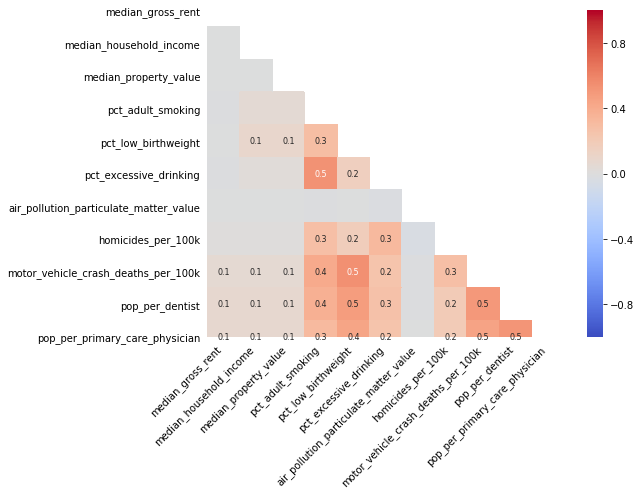

In [8]:
import missingno as msno
msno.heatmap(all_data, cmap='coolwarm', figsize=(8,6), fontsize=10);

The  correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another. The heatmap mostly shows moderate to no nullity correlation between missing values.

Deal with missing data by imputation or dropping columns where >60% of entries are missing ('homicides_per_100k'). 

First treat the missing features unique to the train & test sets

In [9]:
same = missing_train_df.index.tolist() == missing_test_df.index.tolist()
print("Training & Test data have missing data in the same features: {}".format(same))
if same==False:
    mismatch = set(missing_train_df.index.tolist()) ^ set(missing_test_df.index.tolist()) # Symmetric difference
    print("Mismatched missing features: {}".format(mismatch))

Training & Test data have missing data in the same features: False
Mismatched missing features: {'median_gross_rent', 'median_household_income', 'median_property_value'}


In [10]:
# Fill unique missing features using the median training set value
train_data.loc[train_data['median_property_value'].isnull(),'median_property_value'] = train_data['median_property_value'].median()
train_data.loc[train_data['median_household_income'].isnull(),'median_household_income'] = train_data['median_household_income'].median()
test_data.loc[test_data['median_gross_rent'].isnull(),'median_gross_rent'] = train_data['median_gross_rent'].median()

# Drop column with >60% missing data
train_data.drop(columns='homicides_per_100k', inplace=True)
test_data.drop(columns='homicides_per_100k', inplace=True)

In [11]:
missing_train_df = train_data.isnull().sum()
missing_train_df = pd.DataFrame(missing_train_df[missing_train_df>0].sort_values(ascending=False), columns=['Total'])
missing_train_df['%'] = np.round((missing_train_df['Total']/len(train_data))*100, decimals=2)
print("Missing features in Train data")
missing_train_df

Missing features in Train data


,Total,%
pct_excessive_drinking,810,31.81
pct_adult_smoking,408,16.03
motor_vehicle_crash_deaths_per_100k,308,12.10
pop_per_dentist,190,7.46
pop_per_primary_care_physician,175,6.87
pct_low_birthweight,126,4.95
air_pollution_particulate_matter_value,1,0.04


In [12]:
missing_test_df = test_data.isnull().sum()
missing_test_df = pd.DataFrame(missing_test_df[missing_test_df>0].sort_values(ascending=False), columns=['Total'])
missing_test_df['%'] = np.round((missing_test_df['Total']/len(test_data))*100, decimals=2)
print("Missing features in Test data")
missing_test_df

Missing features in Test data


,Total,%
pct_excessive_drinking,718,29.67
pct_adult_smoking,344,14.21
motor_vehicle_crash_deaths_per_100k,272,11.24
pop_per_dentist,163,6.74
pop_per_primary_care_physician,143,5.91
pct_low_birthweight,107,4.42
air_pollution_particulate_matter_value,3,0.12


In [13]:
same = missing_train_df.index.tolist() == missing_test_df.index.tolist()
print("Training & Test data have missing data in the same features: {}".format(same))
if same==False:
    mismatch = set(missing_train_df.index.tolist()) ^ set(missing_test_df.index.tolist()) # Symmetric difference
    print("Mismatched missing features: {}".format(mismatch))

Training & Test data have missing data in the same features: True


<br>
<br>

In [14]:
class MissingData(BaseEstimator, TransformerMixin):
    """
    Custom transformer following scikit-learn's transformer API. Used to 
    deal with NUMERICAL missing data for the eviction dataset.
    Accepts Pandas DataFrames not data arrays.
    
    Parameters
    ----------
    impute_method: string
        Toggle between imputation methods. Use one of either
        'median' to impute using the median value or 'iterative' to use 
        fancyimpute's IterativeImputer object (based off of MICE).
    """
    def __init__(self, impute_method='median'):
        
        if impute_method not in {'median', 'iterative'}:
            raise ValueError('Invalid impute_method "%s"' % impute_method)
        
        if impute_method=='median':
            self.imputer = SimpleImputer(strategy='median')
        else:
            self.imputer = IterativeImputer(sample_posterior=True, max_iter=100)
        self.impute_method = impute_method
    
    def fit(self, X, y=None):
        """
        Use only numerical features (and non-identifiers) from the training set to 
        fit missing features. The dataset that is transformed must have the same
        columns as the dataset that the imputer was fitted on.
        """
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(exclude=['int64', 'object'])
        self.missing_feats = X_copy.columns.tolist()
        X_copy_values = X_copy.values
        self.imputer.fit(X_copy_values)
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        missing = X_copy[self.missing_feats]
        X_copy.drop(columns=self.missing_feats, inplace=True)
        missing = self.imputer.transform(missing)
        missing_df = pd.DataFrame(data=missing, columns=self.missing_feats)
        X_copy = X_copy.merge(missing_df, left_index=True, right_index=True)
        return X_copy

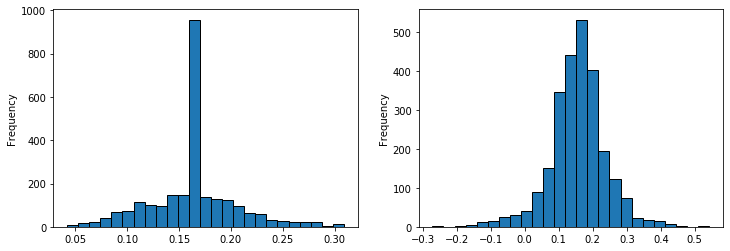

In [17]:
# Compare median and iterative imputer 
missing_imp = MissingData(impute_method='median')

a = missing_imp.fit_transform(train_data)
b = missing_imp.transform(test_data)

missing_imp = MissingData(impute_method='iterative')

c = missing_imp.fit_transform(train_data)
d = missing_imp.transform(test_data)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
a['pct_excessive_drinking'].plot.hist(bins=25, edgecolor='k', ax=ax)
ax = fig.add_subplot(122)
c['pct_excessive_drinking'].plot.hist(bins=25, edgecolor='k')

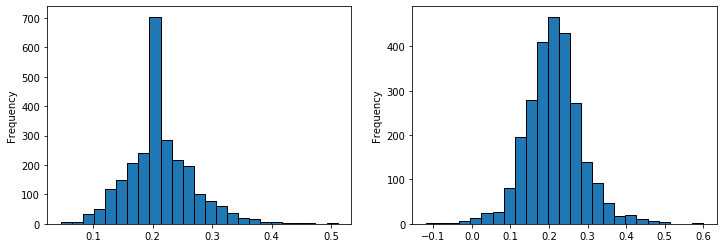

In [18]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
a['pct_adult_smoking'].plot.hist(bins=25, edgecolor='k')
ax = fig.add_subplot(122)
c['pct_adult_smoking'].plot.hist(bins=25, edgecolor='k')

IterativeImputer generates more normally distributed and less peaky features

In [19]:
missing_imp = MissingData(impute_method='iterative')

train_data = missing_imp.fit_transform(train_data)
test_data = missing_imp.transform(test_data)

Clip values of imputed features that are <0.

In [20]:
imp_feats = missing_train_df.index.tolist()

train_data[imp_feats] = train_data[imp_feats].apply(lambda x: np.clip(x, 0, None))
test_data[imp_feats] = test_data[imp_feats].apply(lambda x: np.clip(x, 0, None))

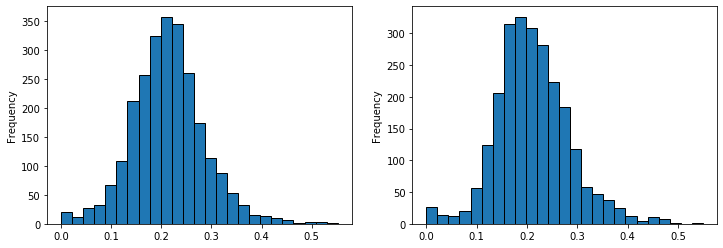

In [21]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
train_data['pct_adult_smoking'].plot.hist(bins=25, edgecolor='k')
ax = fig.add_subplot(122)
test_data['pct_adult_smoking'].plot.hist(bins=25, edgecolor='k')

Any more missing values?

In [22]:
missing_train_df = train_data.isnull().sum()
missing_train_df = pd.DataFrame(missing_train_df[missing_train_df>0].sort_values(ascending=False), columns=['Total'])
missing_train_df['%'] = np.round((missing_train_df['Total']/len(train_data))*100, decimals=2)
print("Missing features in Train data")
missing_train_df

Missing features in Train data


,Total,%


In [23]:
missing_test_df = test_data.isnull().sum()
missing_test_df = pd.DataFrame(missing_test_df[missing_test_df>0].sort_values(ascending=False), columns=['Total'])
missing_test_df['%'] = np.round((missing_test_df['Total']/len(test_data))*100, decimals=2)
print("Missing features in Test data")
missing_test_df

Missing features in Test data


,Total,%


<br>
<br>

## Transform categorical features

In [24]:
train_data.select_dtypes(include=['int64','object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Data columns (total 8 columns):
row_id                              2546 non-null int64
county_code                         2546 non-null object
year                                2546 non-null object
state                               2546 non-null object
rucc                                2546 non-null object
urban_influence                     2546 non-null object
economic_typology                   2546 non-null object
heart_disease_mortality_per_100k    2546 non-null int64
dtypes: int64(2), object(6)
memory usage: 159.2+ KB


Drop ID columns (row_id, county code, year, state) and produce dummy variables for the rest of the nominal categorical variables during modelling stage.

In [25]:
train_row_id = train_data['row_id']
test_row_id = test_data['row_id']
train_data.drop(columns=['row_id', 'county_code', 'year', 'state'], inplace=True)
test_data.drop(columns=['row_id', 'county_code', 'year', 'state'], inplace=True)

# Keep seperate for EDA
#train_data_ohe = pd.get_dummies(train_data, drop_first=True).astype('float64')
#test_data_ohe = pd.get_dummies(test_data, drop_first=True).astype('float64')

<br>
<br>

# Exploratory Data Analysis

<br>
<br>

## Feature/Target transformations

### Target variable

In [26]:
train_labels['evictions'].describe()

count     2546.000000
mean       378.048311
std       1405.276610
min          0.000000
25%          4.000000
50%         29.000000
75%        160.750000
max      29251.000000
Name: evictions, dtype: float64

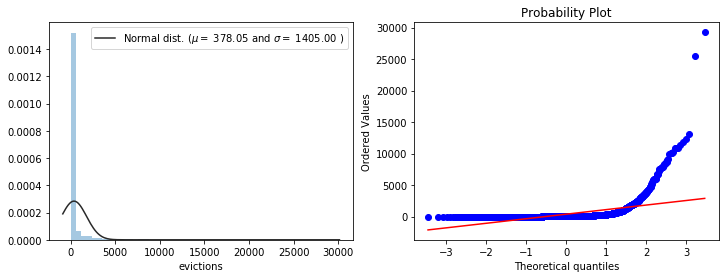

In [27]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)

(mu,sigma) = norm.fit(train_labels['evictions'])
sns.distplot(train_labels['evictions'], fit=norm, kde=False, ax=ax)
ax.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

ax = fig.add_subplot(122)
ax = probplot(train_labels['evictions'], plot=ax)

**log(1+x) transform**

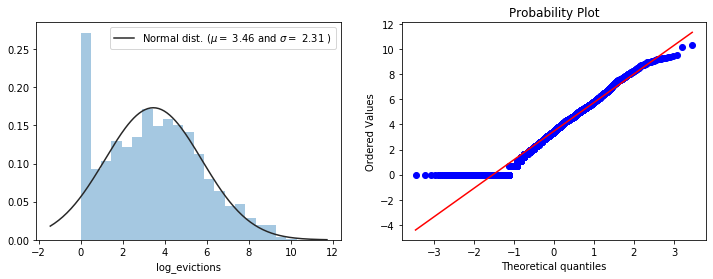

In [28]:
train_labels['log_evictions'] = train_labels['evictions'].apply(lambda x: np.log1p(x))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
(mu,sigma) = norm.fit(train_labels['log_evictions'])
sns.distplot(train_labels['log_evictions'], fit=norm, kde=False, ax=ax)
ax.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

ax = fig.add_subplot(122)
probplot(train_labels['log_evictions'], plot=ax);

**boxcox transform**

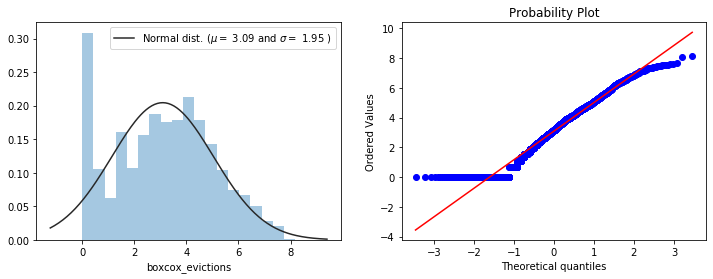

In [29]:
boxcox_evictions, _ = boxcox(train_labels['evictions']+1)
train_labels['boxcox_evictions'] = boxcox_evictions

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
(mu,sigma) = norm.fit(train_labels['boxcox_evictions'])
sns.distplot(train_labels['boxcox_evictions'], fit=norm, kde=False, ax=ax)
ax.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

ax = fig.add_subplot(122)
probplot(train_labels['boxcox_evictions'], plot=ax);

Try use log_evictions as target

<br>
<br>

### Skewed features

In [30]:
numerical_feats = train_data.select_dtypes(exclude=['object']).columns.tolist()

pos_skewed_feats = train_data[numerical_feats].apply(lambda x: skew(x))
pos_skewed_feats = pos_skewed_feats[pos_skewed_feats > 0.75]
pos_skewed_feats = pos_skewed_feats.index

neg_skewed_feats = train_data[numerical_feats].apply(lambda x: skew(x))
neg_skewed_feats = neg_skewed_feats[neg_skewed_feats < -0.75]
neg_skewed_feats = neg_skewed_feats.index

print(list(pos_skewed_feats))
print(list(neg_skewed_feats))

['population', 'renter_occupied_households', 'pct_renter_occupied', 'median_gross_rent', 'median_household_income', 'median_property_value', 'pct_af_am', 'pct_hispanic', 'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other', 'poverty_rate', 'pct_unemployment', 'pct_uninsured_children', 'pct_low_birthweight', 'motor_vehicle_crash_deaths_per_100k', 'pop_per_dentist', 'pop_per_primary_care_physician', 'pct_adults_less_than_a_high_school_diploma', 'pct_adults_bachelors_or_higher', 'birth_rate_per_1k']
['pct_white', 'pct_female']


Transform positve skewed features using log(1+x) transformation

In [31]:
train_data_tranf = train_data.copy()

# log(1+x)
pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

# (box_cox)
#pos_skewed_feat_names = ['boxcox_'+str(col) for col in pos_skewed_feats]
#train_data_tranf[pos_skewed_feat_names] = train_data_tranf[pos_skewed_feats].apply(lambda x: boxcox(x+1)[0])

Check transformation for 'population'

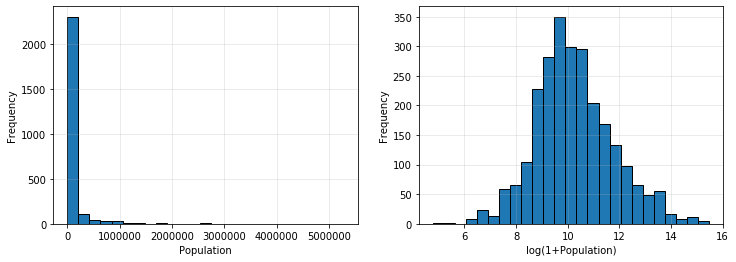

In [32]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)

train_data['population'].plot.hist(bins=25, edgecolor='k', ax=ax)
ax.set_xlabel("Population");
ax.grid(True, alpha=0.3)

ax = fig.add_subplot(122)
train_data_tranf['log_population'].plot.hist(bins=25, edgecolor='k', ax=ax)
ax.grid(True, alpha=0.3)
ax.set_xlabel("log(1+Population)");

<br>
<br>

### Multicollinearity

In [102]:
corr = train_data_tranf.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.80)]
to_drop

['log_renter_occupied_households', 'log_median_property_value']

In [103]:
corr['log_renter_occupied_households'].sort_values(ascending=False).head().values

log_renter_occupied_households    1.000000
log_population                    0.989159
log_median_gross_rent             0.610876
log_pct_asian                     0.539528
log_median_property_value         0.521677
Name: log_renter_occupied_households, dtype: float64

In [104]:
corr['log_median_property_value'].sort_values(ascending=False).head()

log_median_property_value             1.000000
log_median_gross_rent                 0.809780
log_pct_adults_bachelors_or_higher    0.747298
log_median_household_income           0.700923
log_population                        0.525054
Name: log_median_property_value, dtype: float64

- 'renter_occupied_households' is highly correlated (0.99) with 'population'
- 'median_property_value' is highly correlated (0.81) with 'median_gross_rent'

In [105]:
train_data_copy = train_data_tranf.copy()
train_data_copy['evictions'] = train_labels['evictions']
train_data_copy['log_evictions'] = train_labels['log_evictions']

pd.DataFrame({'log_renter_occupied_households':train_data_copy['log_renter_occupied_households'].values,
              'log_population':train_data_copy['log_population'].values, 
              'log_median_property_value':train_data_copy['log_median_property_value'].values,
              'log_median_gross_rent':train_data_copy['log_median_gross_rent'].values,
              'log_evictions':train_data_copy['log_evictions'].values}).corr()

,log_renter_occupied_households,log_population,log_median_property_value,log_median_gross_rent,log_evictions
log_renter_occupied_households,1.000000,0.989159,0.521677,0.610876,0.886482
log_population,0.989159,1.000000,0.525054,0.615946,0.879176
log_median_property_value,0.521677,0.525054,1.000000,0.809780,0.447003
log_median_gross_rent,0.610876,0.615946,0.809780,1.000000,0.540738
log_evictions,0.886482,0.879176,0.447003,0.540738,1.000000


In [106]:
del(train_data_copy)

I'll be conservative at this stage and thus will not prune the multicollinear features right now. Instead I'll allow the feature selection packages used during the modelling stage to prune features if doing so will result in a better model.

<br>
<br>

### Correlations

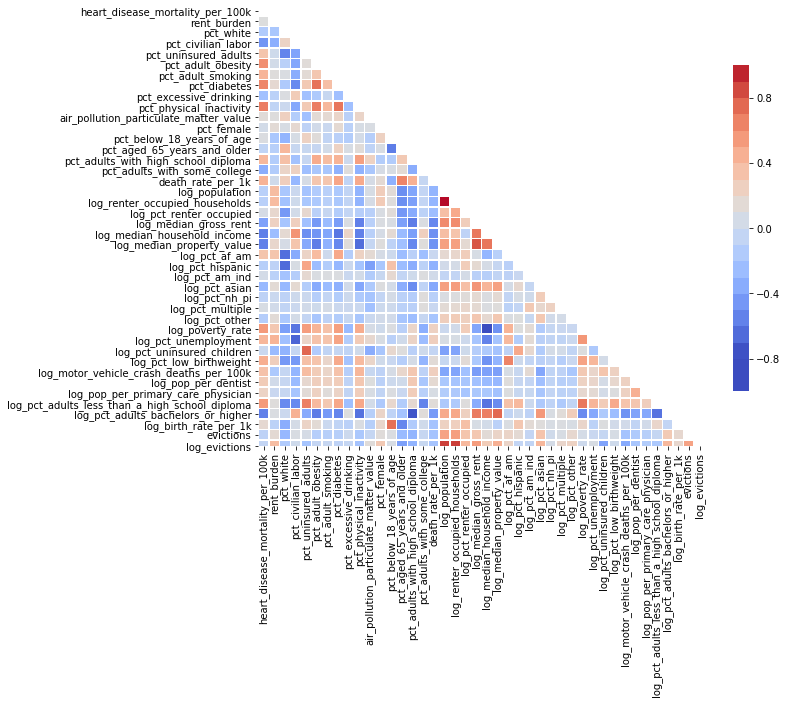

In [109]:
train_data_copy = train_data_tranf.copy()
train_data_copy['evictions'] = train_labels['evictions']
train_data_copy['log_evictions'] = train_labels['log_evictions']

mask = np.zeros_like(train_data_copy.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8));
sns.heatmap(train_data_copy.corr(), linewidths=0.5, cmap='coolwarm', mask=mask,
            cbar_kws={'boundaries':np.linspace(-1,1, 21).tolist(), 'shrink':0.75});

del(train_data_copy)

<br>
<br>

### Pairplot

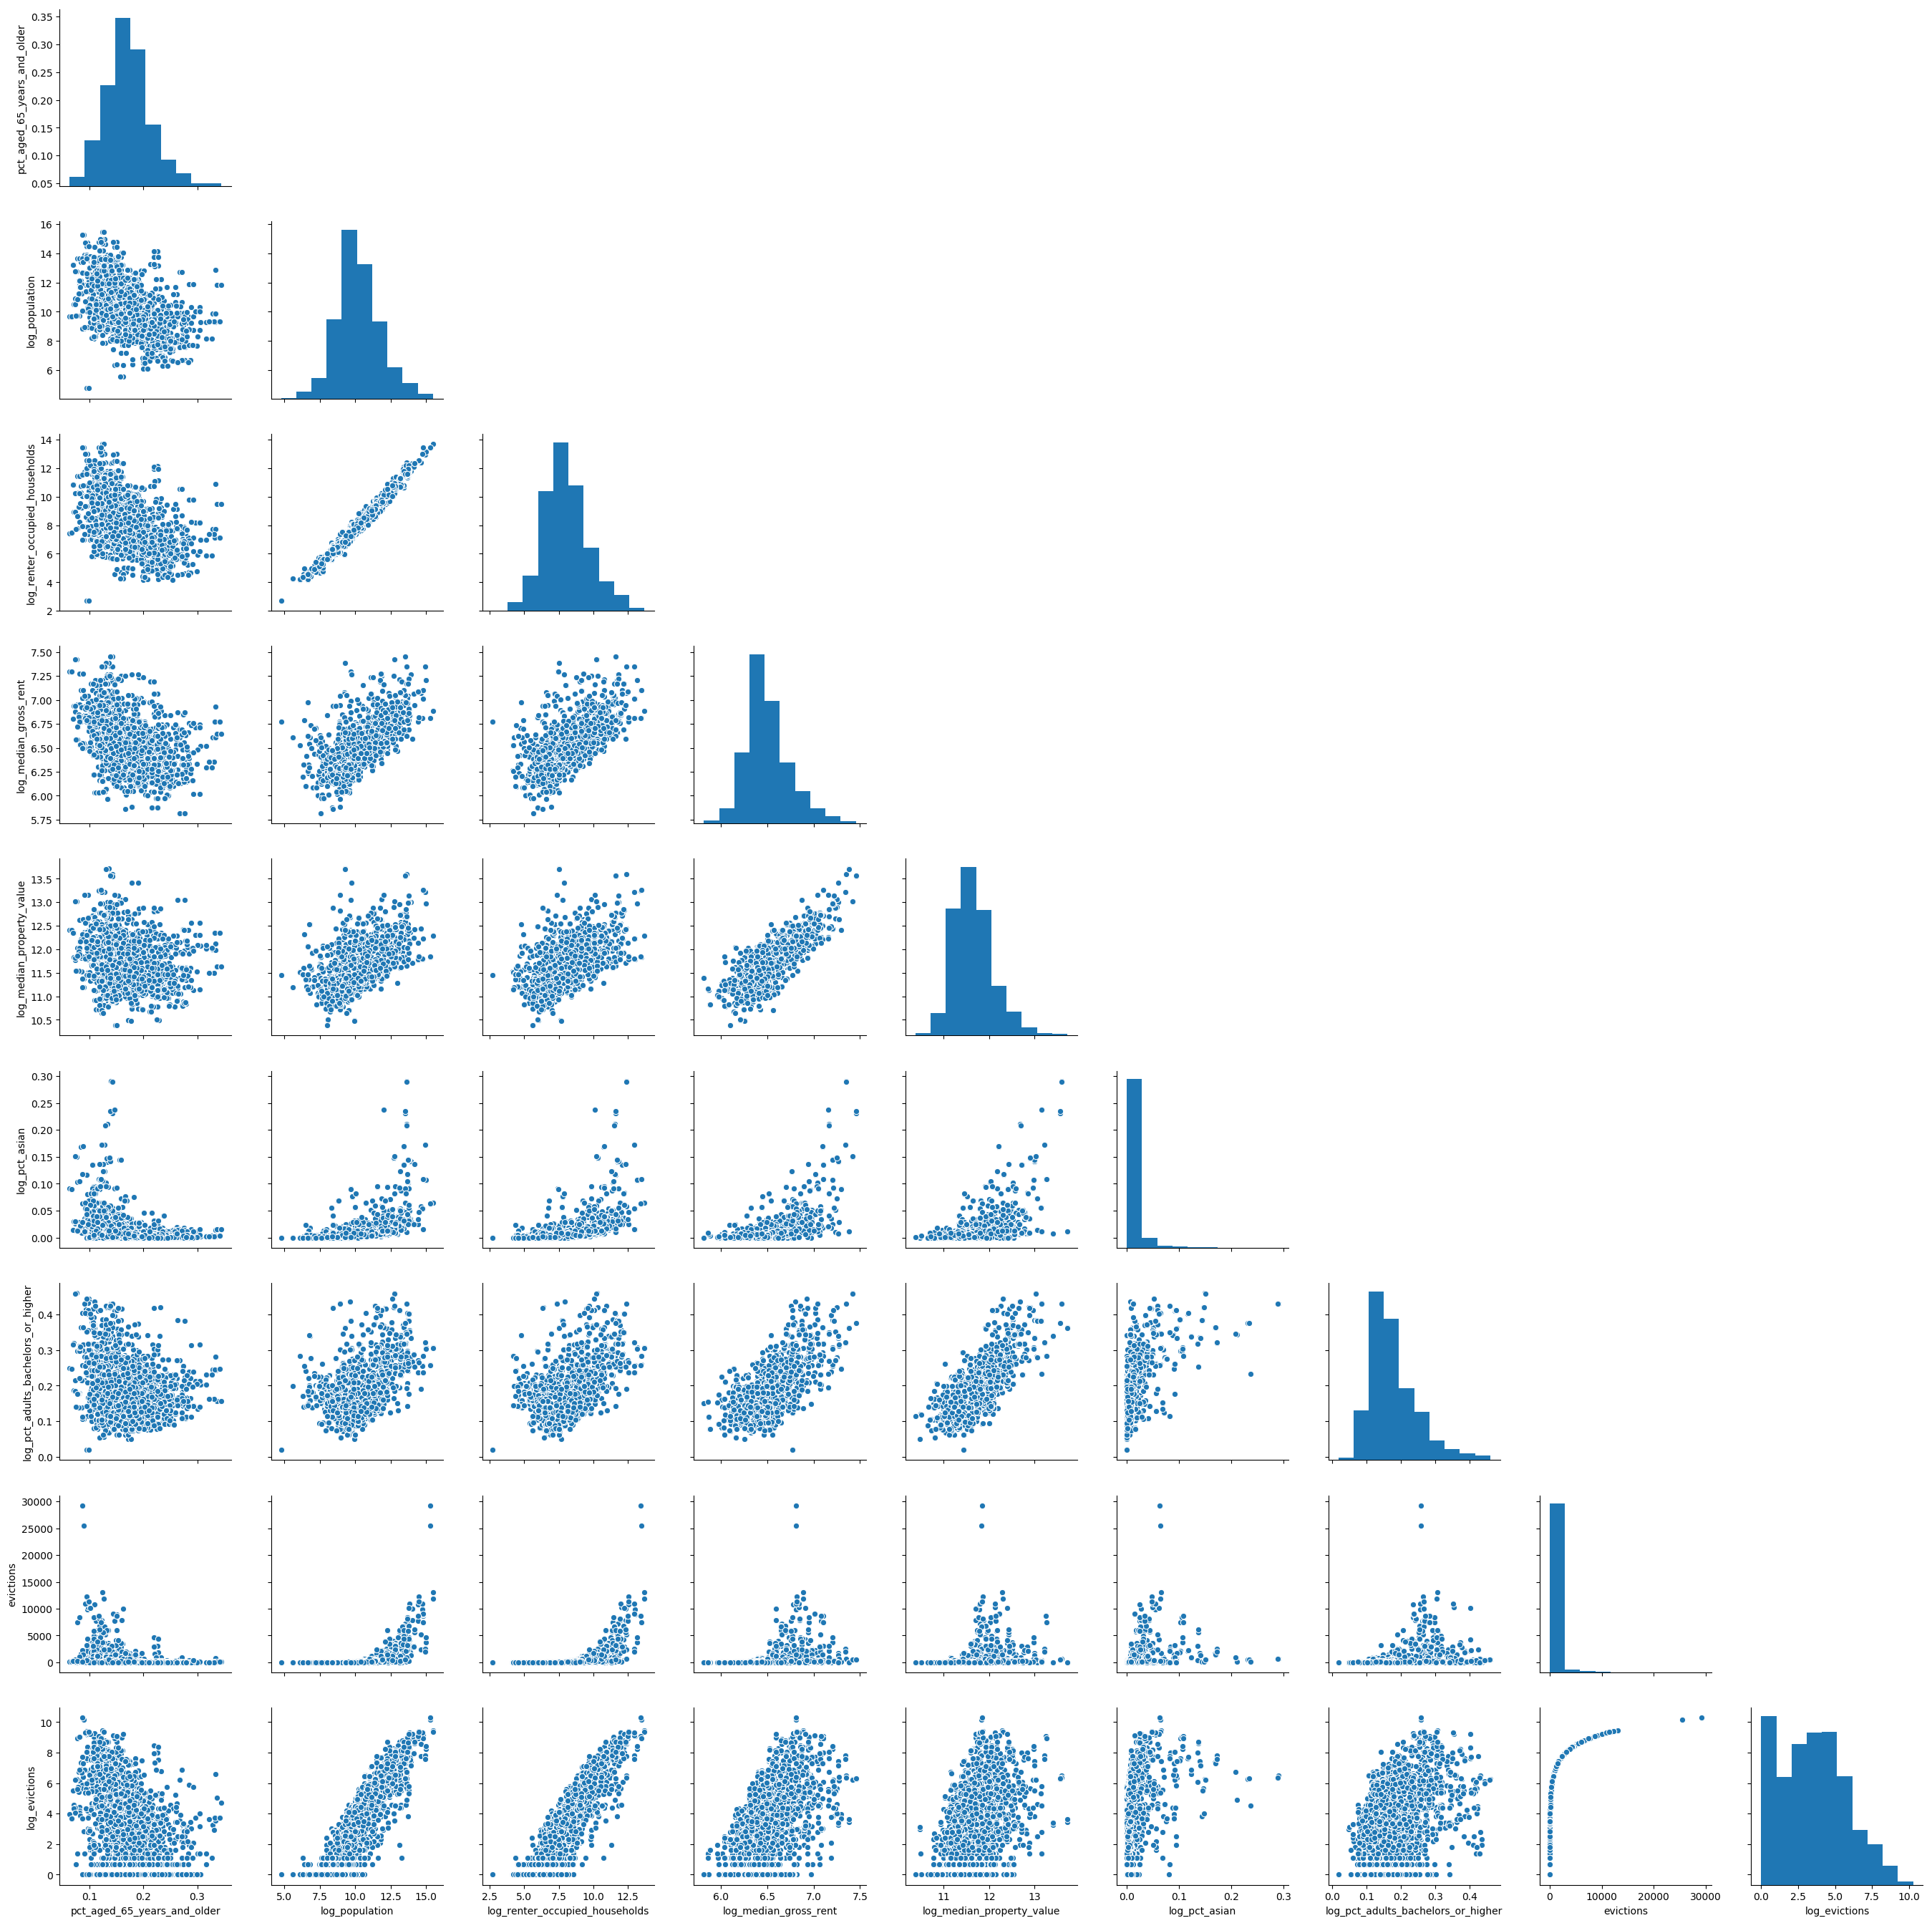

In [60]:
train_data_copy = train_data_tranf.copy()
train_data_copy['evictions'] = train_labels['evictions']
train_data_copy['log_evictions'] = train_labels['log_evictions']

corr = np.abs(train_data_copy.corr()['log_evictions'])
feats = corr[corr>0.4].index

g = sns.pairplot(train_data_copy.loc[:,feats], height=3)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
    
del(train_data_copy)

<br>
<br>

## Outliers

In [35]:
train_labels['evictions'].quantile(0.975)

3570.75

In [36]:
# Drop outliers?

#outlier_idx = train_labels.loc[train_labels['evictions']>15000, 'evictions'].index
#train_data.drop(index=outlier_idx, inplace=True)
#train_labels.drop(index=outlier_idx, inplace=True)

# 3 - 24/01/2019 (97.5%)
#outlier_idx = train_labels.loc[train_labels['evictions']>3571, 'evictions'].index
#train_data.drop(index=outlier_idx, inplace=True)
#train_labels.drop(index=outlier_idx, inplace=True)

<br>
<br>

## Most "important" features

In [113]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("data/train_values.csv")
states = X['state'].values
del(X)

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

y_train = train_labels['evictions'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [114]:
feat_imp_forest = RandomForestRegressor(n_estimators=200, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=4,)
                                    #max_features='sqrt')

sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>500)] += 10

feat_imp_forest.fit(X_train, y_train, sample_weights)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()
feat_import_df.head()

,Feature name,Feature importance,Cumulative importance
0,log_renter_occupied_households,0.359981,0.359981
1,log_population,0.303024,0.663005
2,economic_typology_Mining-dependent,0.046813,0.709819
3,log_pct_af_am,0.034155,0.743974
4,pct_aged_65_years_and_older,0.031878,0.775852


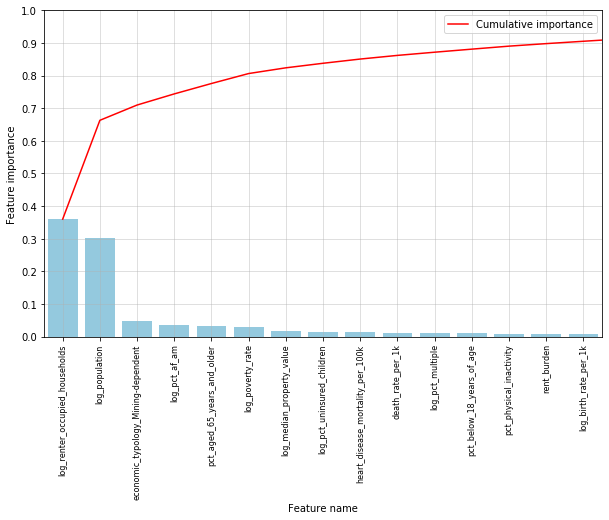

In [117]:
plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

<br>
<br>

# Machine Learning models

<br>
<br>

### What to try:

- Random Forest with log target, removed outliers (2 points) and feature selection
- Random Forest with removed outliers (2 points) and feature selection
- Random Forest with more removed outliers (97.5%ile) and feature selection

<br>
<br>

# 1.

In [37]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("data/train_values.csv")
states = X['state'].values
del(X)

y_train = train_labels['log_evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

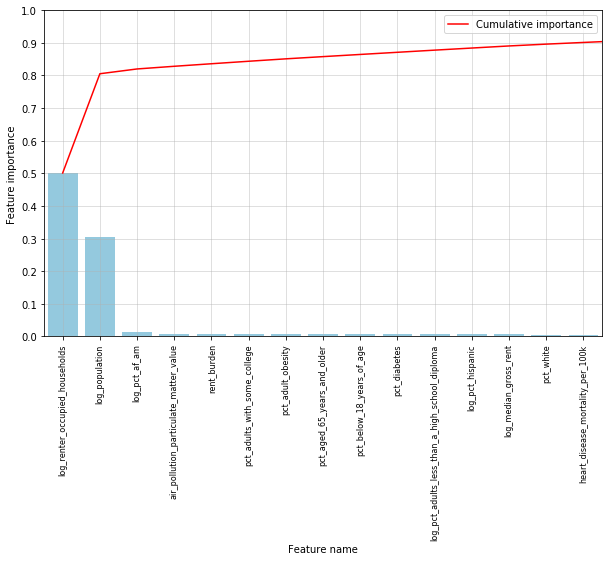

In [38]:
# Most important features

feat_imp_forest = RandomForestRegressor(n_estimators=1000, 
                                        criterion='mse', 
                                        max_depth=15, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]


feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()

plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

In [39]:
# Select 20 most important features
most_imp_feats = feat_import_df.iloc[:20, 0].values

train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("data/train_values.csv")
states = X['state'].values
del(X)

train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

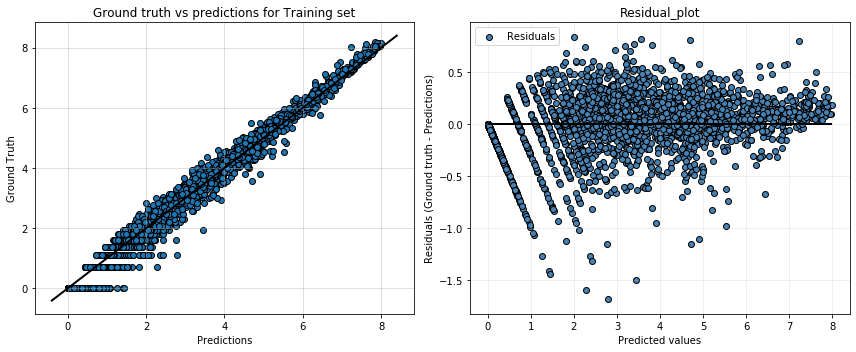

In [40]:
feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['log_evictions'].values

rand_forest = RandomForestRegressor(n_estimators=1000, 
                                    criterion='mse', 
                                    max_depth=15, 
                                    n_jobs=4,)

rand_forest.fit(X_train, y_train)
y_pred_train = rand_forest.predict(X_train)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.scatter(y_pred_train, y_train, edgecolor='k')
ax.set_title("Ground truth vs predictions for Training set")
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
x = np.linspace(*plt.gca().get_xlim())
ax.plot(x, x, color='k', lw=2)
ax.grid(alpha=0.5)

ax = fig.add_subplot(122)
ax.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals (Ground truth - Predictions)');
ax.legend(loc='best')
ax.grid(alpha=0.25)
ax.set_title("Residual_plot")
ax.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.tight_layout();

0.9587211461896595


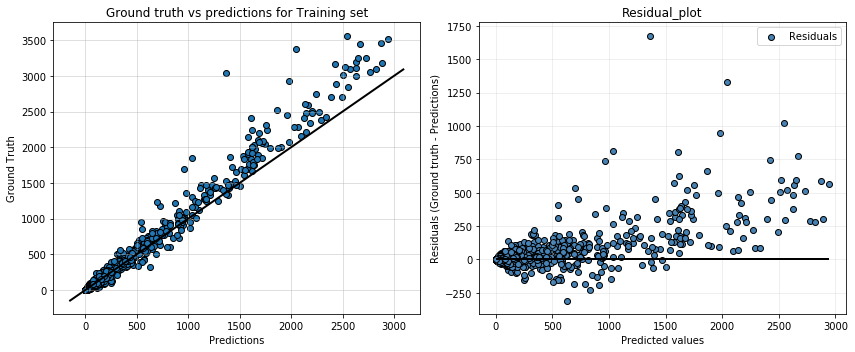

In [41]:
# Reverse log(1+x) transform
y_train = np.exp(y_train)-1
y_pred_train = np.exp(y_pred_train) - 1
print(r2_score(y_train, y_pred_train))

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.scatter(y_pred_train, y_train, edgecolor='k')
ax.set_title("Ground truth vs predictions for Training set")
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
x = np.linspace(*plt.gca().get_xlim())
ax.plot(x, x, color='k', lw=2)
ax.grid(alpha=0.5)

ax = fig.add_subplot(122)
ax.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals (Ground truth - Predictions)');
ax.legend(loc='best')
ax.grid(alpha=0.25)
ax.set_title("Residual_plot")
ax.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.tight_layout();

In [78]:
# Get submission

# Reverse log(1+x) transform
y_pred_test = rand_forest.predict(X_test)
y_pred_test = np.exp(y_pred_test) - 1  

submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)
submission.to_csv("1_24012019_submission.csv", index=False)

<br>
<br>

# 2.

In [42]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("data/train_values.csv")
states = X['state'].values
del(X)

y_train = train_labels['evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

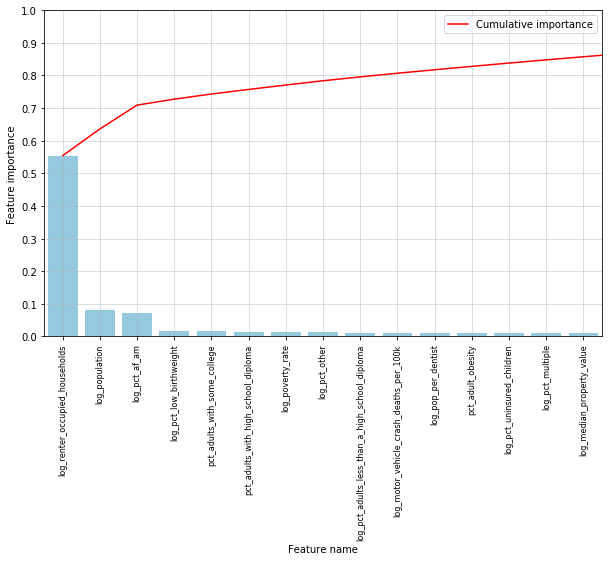

In [43]:
# Most important features

feat_imp_forest = RandomForestRegressor(n_estimators=500, 
                                        criterion='mse', 
                                        max_depth=9, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()

plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

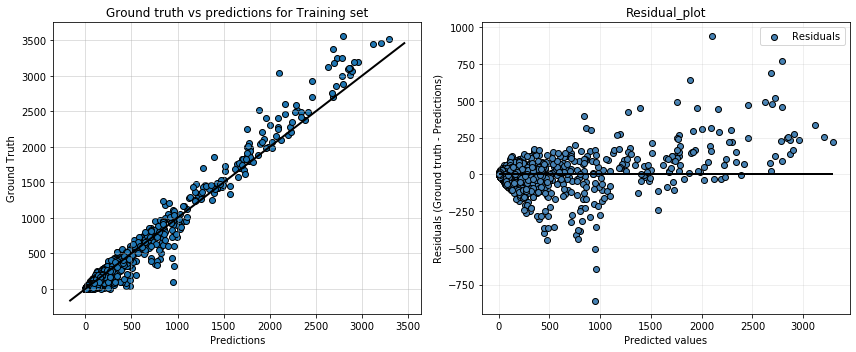

In [44]:
# Select 20 most important features

train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("data/train_values.csv")
states = X['state'].values
del(X)

train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['evictions'].values

rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=4,)

rand_forest.fit(X_train, y_train)
y_pred_train = rand_forest.predict(X_train)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.scatter(y_pred_train, y_train, edgecolor='k')
ax.set_title("Ground truth vs predictions for Training set")
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
x = np.linspace(*plt.gca().get_xlim())
ax.plot(x, x, color='k', lw=2)
ax.grid(alpha=0.5)

ax = fig.add_subplot(122)
ax.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals (Ground truth - Predictions)');
ax.legend(loc='best')
ax.grid(alpha=0.25)
ax.set_title("Residual_plot")
ax.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.tight_layout();

In [75]:
cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=1)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

y_pred_test = rand_forest.predict(X_test)
submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)
submission['evictions']
submission.to_csv("2_24012019_submission.csv", index=False)

R2: 0.894 +/- 0.054


Very poor test performance

<br>
<br>

**Discussion**

Fitting on the log label resulted in poor performance (heavily overfitted) however, removing >97.5%ile extreme values resulted in very poor performance (0.4 R2). Best single model (Random Forest) performance resulted from removing the two most extreme points, and selecting 20 features (0.75 R2). Because removing the extreme points resulted in such a big performance hit, it is likely that the training points with high eviction values should have a big influence on how the model should act at such extreme ranges.

To try next:

1. Keep all points, add extra weight to the extreme points, feature selection (20?), Random Forest.

If the above model performs worse then:

2. Produce an averaging ensemble of models using the same features and weighted points as 1 above

3. ??

<br>
<br>

# 1.

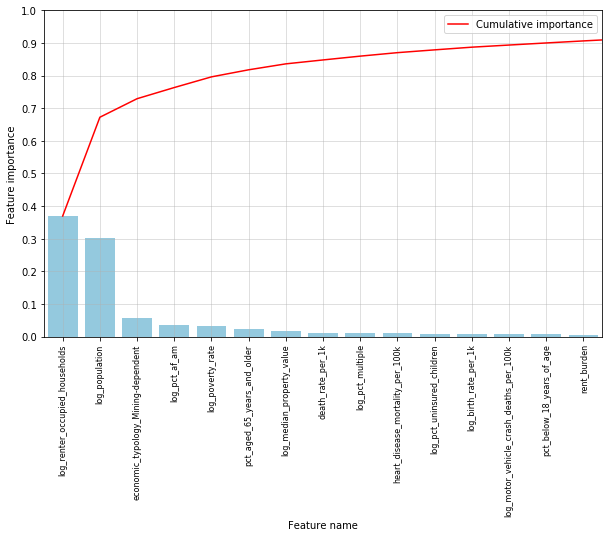

In [34]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("data/train_values.csv")
states = X['state'].values
del(X)

y_train = train_labels['evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

# Most important features

feat_imp_forest = RandomForestRegressor(n_estimators=500, 
                                        criterion='mse', 
                                        max_depth=9, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()

plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

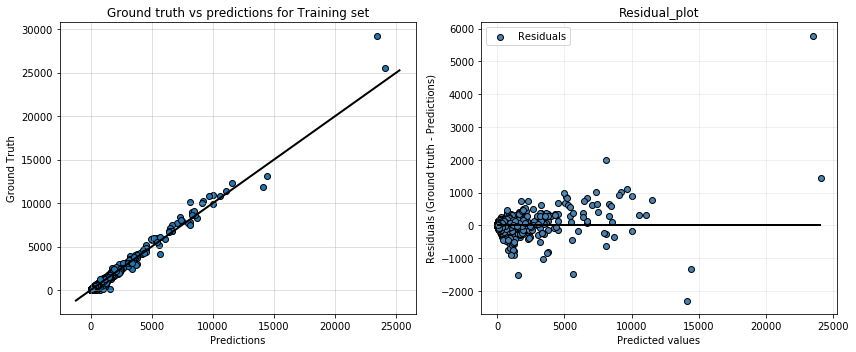

In [35]:
# Select 20 most important features
most_imp_feats = feat_import_df.iloc[:20, 0].values

train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

train_data_tranf = pd.get_dummies(train_data_tranf, drop_first=True)
test_data_tranf = pd.get_dummies(test_data_tranf, drop_first=True)

train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['evictions'].values

sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>16000)] += 14

rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=3,)

rand_forest.fit(X_train, y_train, sample_weights)

y_pred_train = rand_forest.predict(X_train)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.scatter(y_pred_train, y_train, edgecolor='k')
ax.set_title("Ground truth vs predictions for Training set")
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
x = np.linspace(*plt.gca().get_xlim())
ax.plot(x, x, color='k', lw=2)
ax.grid(alpha=0.5)

ax = fig.add_subplot(122)
ax.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals (Ground truth - Predictions)');
ax.legend(loc='best')
ax.grid(alpha=0.25)
ax.set_title("Residual_plot")
ax.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.tight_layout();

In [36]:
cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)
submission.to_csv("1_22012019_submission.csv", index=False)

R2: 0.869 +/- 0.074


**0.8200**

<br>
<br>

# 2. Averaging Ensemble

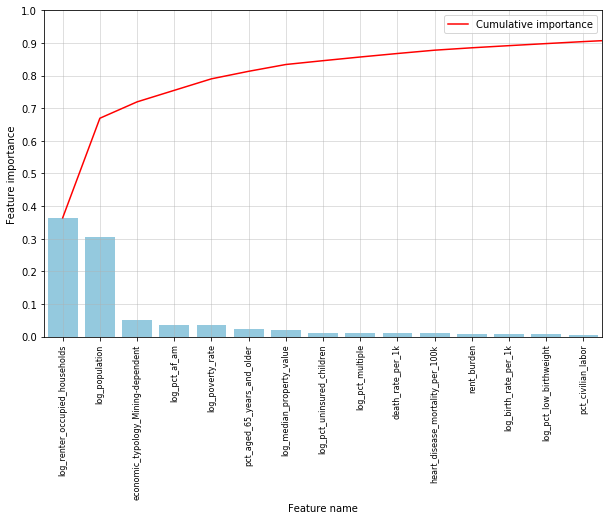

In [33]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("data/train_values.csv")
states = X['state'].values
del(X)

y_train = train_labels['evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

# Most important features

feat_imp_forest = RandomForestRegressor(n_estimators=750, 
                                        criterion='mse', 
                                        max_depth=15, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()

plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

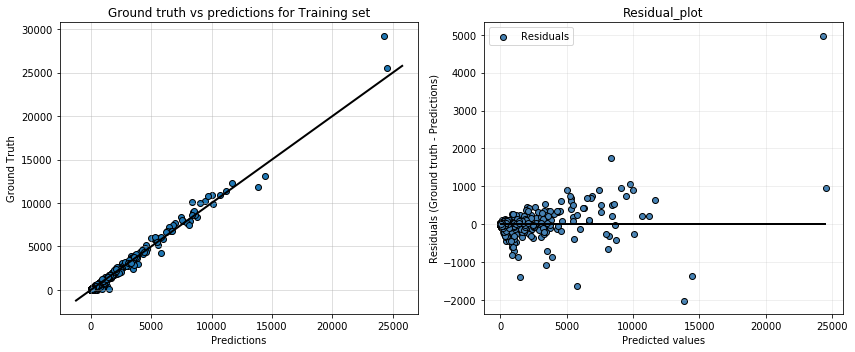

In [34]:
# Select 20 most important features
most_imp_feats = feat_import_df.iloc[:20, 0].values

train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

train_data_tranf = pd.get_dummies(train_data_tranf, drop_first=True)
test_data_tranf = pd.get_dummies(test_data_tranf, drop_first=True)

train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['evictions'].values

# Increase sample weight
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>16000)] += 49

rand_forest = RandomForestRegressor(n_estimators=750, 
                                    criterion='mse', 
                                    max_depth=15, 
                                    n_jobs=3,)

rand_forest.fit(X_train, y_train, sample_weights)

y_pred_train = rand_forest.predict(X_train)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.scatter(y_pred_train, y_train, edgecolor='k')
ax.set_title("Ground truth vs predictions for Training set")
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
x = np.linspace(*plt.gca().get_xlim())
ax.plot(x, x, color='k', lw=2)
ax.grid(alpha=0.5)

ax = fig.add_subplot(122)
ax.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals (Ground truth - Predictions)');
ax.legend(loc='best')
ax.grid(alpha=0.25)
ax.set_title("Residual_plot")
ax.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.tight_layout();

In [35]:
cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))
y_pred_test_rf1 = rand_forest.predict(X_test)

R2: 0.879 +/- 0.063


<br>
<br>

**XGBoost**

[15:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


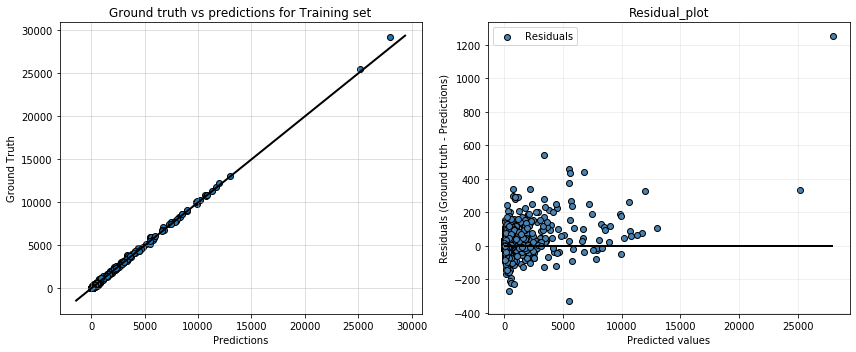

In [49]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train<676)] += 1
sample_weights[np.argwhere(y_train<1876)] += 1
sample_weights[np.argwhere(y_train<3571)] += 2
sample_weights[np.argwhere(y_train>16000)] += 0

xgb_regr = XGBRegressor(learning_rate=0.03, 
                        n_estimators=200,
                        max_depth=7,
                        n_jobs=4)

xgb_regr.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_train = xgb_regr.predict(X_train)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.scatter(y_pred_train, y_train, edgecolor='k')
ax.set_title("Ground truth vs predictions for Training set")
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
x = np.linspace(*plt.gca().get_xlim())
ax.plot(x, x, color='k', lw=2)
ax.grid(alpha=0.5)

ax = fig.add_subplot(122)
ax.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals (Ground truth - Predictions)');
ax.legend(loc='best')
ax.grid(alpha=0.25)
ax.set_title("Residual_plot")
ax.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.tight_layout();

In [ ]:
cvs = cross_val_score(xgb_regr, X_train, y_train, scoring='r2', cv=10, n_jobs=1)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)));
y_pred_test_xgb = xgb_regr.predict(X_test)
# R2: 0.899 +/- 0.067

<br>
<br>

**Random Forest 2**

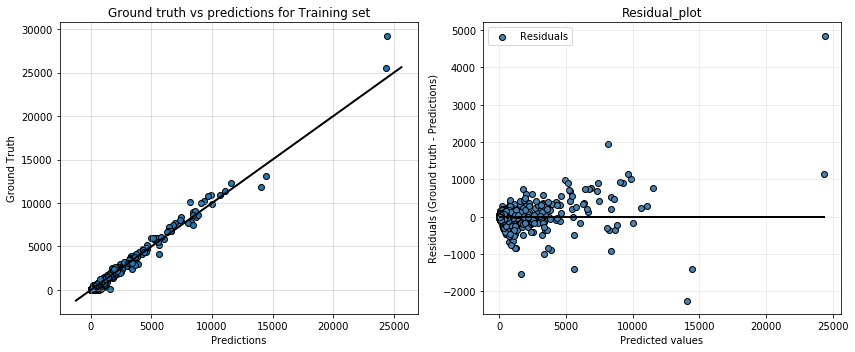

In [61]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>16000)] += 14

rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=3,)

rand_forest.fit(X_train, y_train, sample_weights)

y_pred_train = rand_forest.predict(X_train)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.scatter(y_pred_train, y_train, edgecolor='k')
ax.set_title("Ground truth vs predictions for Training set")
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
x = np.linspace(*plt.gca().get_xlim())
ax.plot(x, x, color='k', lw=2)
ax.grid(alpha=0.5)

ax = fig.add_subplot(122)
ax.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals (Ground truth - Predictions)');
ax.legend(loc='best')
ax.grid(alpha=0.25)
ax.set_title("Residual_plot")
ax.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.tight_layout();

In [56]:
cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))
y_pred_test_rf2 = rand_forest.predict(X_test)

R2: 0.874 +/- 0.078


<br>
<br>

**GBDT**

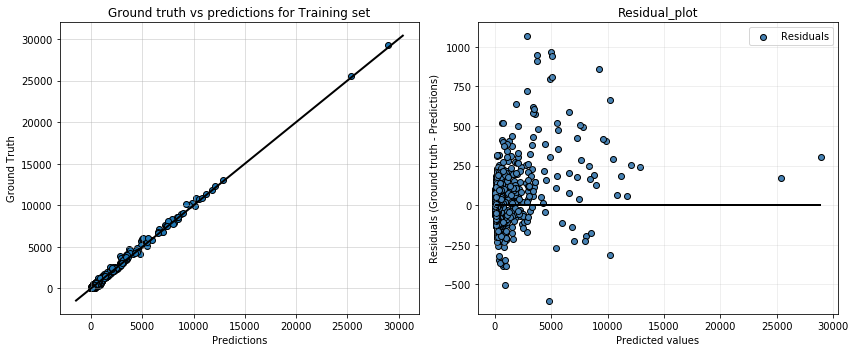

In [58]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train<676)] += 1
sample_weights[np.argwhere(y_train<1876)] += 1
sample_weights[np.argwhere(y_train<3571)] += 6
sample_weights[np.argwhere(y_train>16000)] += 0

grad_boost_regr = GradientBoostingRegressor(loss='ls', 
                                            learning_rate=0.03, 
                                            n_estimators=200, 
                                            max_depth=5)

grad_boost_regr.fit(X_train, y_train, sample_weights)
y_pred_train = grad_boost_regr.predict(X_train)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.scatter(y_pred_train, y_train, edgecolor='k')
ax.set_title("Ground truth vs predictions for Training set")
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
x = np.linspace(*plt.gca().get_xlim())
ax.plot(x, x, color='k', lw=2)
ax.grid(alpha=0.5)

ax = fig.add_subplot(122)
ax.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals (Ground truth - Predictions)');
ax.legend(loc='best')
ax.grid(alpha=0.25)
ax.set_title("Residual_plot")
ax.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.tight_layout();

In [59]:
cvs = cross_val_score(grad_boost_regr, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))
y_pred_test_gbdt = grad_boost_regr.predict(X_test)

# R2: 0.901 +/- 0.068

R2: 0.892 +/- 0.076


In [60]:
print(y_pred_test_rf1)
print(y_pred_test_rf2)
print(y_pred_test_gbdt)
print(y_pred_test_xgb)

[913.5223746  252.23619013   2.04904989 ... 624.93573555 257.32035081
 422.58988869]
[904.15105633 254.70941951   1.09112793 ... 618.22596958 244.98034245
 429.95103137]
[1027.58023512  259.85581636    4.54691222 ...  442.63734648  212.27998147
  294.97281572]
[817.45496   255.89668     3.4237945 ... 435.99905   216.61023
 282.67245  ]


In [ ]:
# Average predictions
y_pred_test = (y_pred_test_rf1 + y_pred_test_rf2 + y_pred_test_gbdt + y_pred_test_xgb)/4

submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)
submission.to_csv("2_25012019_submission.csv", index=False)

**0.8256**